## EDA and Target Distribution Analysis

In this notebook, we will explore the cleaned `reviews.csv` dataset to gain insights into the data and make informed decisions for model building.

---

### Objectives of EDA

1. **Understand the distribution of the target variable (`Score`)**
   - Determine if the classification task should be binary or multiclass
   - Identify class imbalance

2. **Analyze numeric features:**
   - `HelpfulnessNumerator` and `HelpfulnessDenominator`
   - Explore distributions and detect outliers
   - Create new features like `helpfulness_ratio`

3. **Analyze text features:**
   - Review text length distribution
   - Identify unusually short or long reviews
   - Optional: Explore frequent words using word cloud or frequency plot

4. **Guide feature engineering and preprocessing decisions**
   - Based on EDA results, we'll decide:
     - Whether to drop or keep certain features
     - How to encode the labels
     - Whether to clean or transform text further

---

###  Key Plots to Use

- `sns.countplot()` – Review score distribution
- `plt.pie()` – Score proportions
- `sns.histplot()` – Helpfulness & review length
- `sns.boxplot()` – Outliers in helpfulness or length
- `wordcloud.WordCloud` (optional) – Top review words
- `sns.heatmap()` – Correlation of numerical features

---

###  Next Steps After EDA

- Feature Engineering (e.g., helpfulness ratio, review length)
- Label Encoding (binary or multiclass)
- Text Vectorization (TF-IDF or CountVectorizer)
- Model training and evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
df = pd.read_csv('cleaned_reviews.csv')

### 1. Understanding the Target Varable - Score

/var/folders/5r/bcx860m166zcvyg920t37__h0000gn/T/ipykernel_53333/3075132215.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=df, palette='pastel')


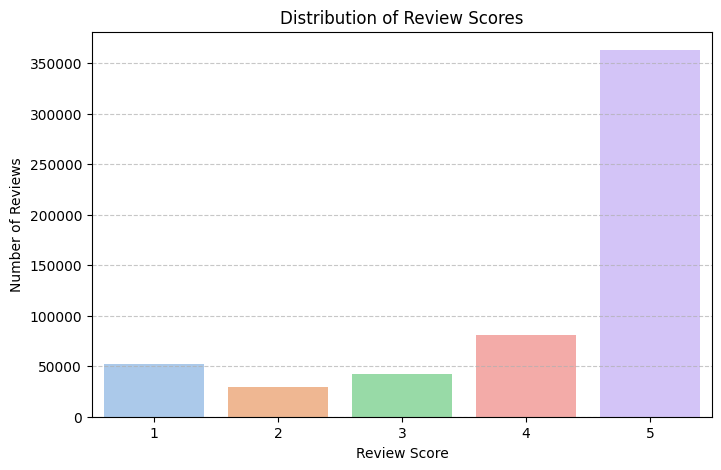

In [2]:
# Count Plot to visualise the review distribution

plt.figure(figsize=(8, 5))
sns.countplot(x='Score', data=df, palette='pastel')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [4]:
# Value Count table  with proportion 

score_counts = df['Score'].value_counts().sort_index()
score_proportions = df['Score'].value_counts(normalize=True).sort_index()

# Display both
print("Score Counts:\n", score_counts)
print("\nScore Proportions (%):\n", (score_proportions * 100).round(2))


Score Counts:
 Score
1     52264
2     29743
3     42638
4     80654
5    363102
Name: count, dtype: int64

Score Proportions (%):
 Score
1     9.19
2     5.23
3     7.50
4    14.19
5    63.88
Name: proportion, dtype: float64


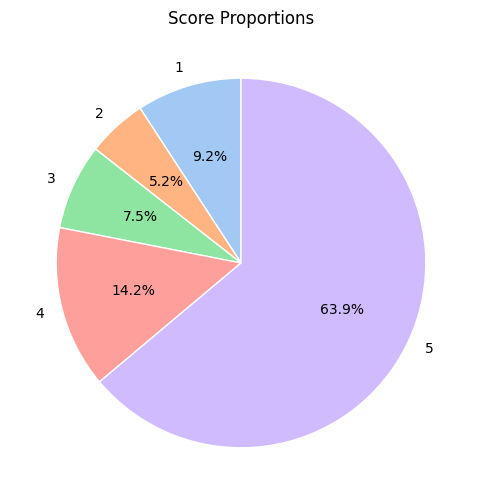

In [5]:
# Pie-chart of Score Distribution 

plt.figure(figsize=(6, 6))
df['Score'].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel'),
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.title("Score Proportions")
plt.ylabel('')
plt.show()

#### Observation – Target Score Distribution

- The distribution of review scores is highly imbalanced.
- Around **64%** of reviews are rated as **5**, showing a strong positive skew.
- Lower scores (1, 2, 3) are significantly underrepresented.
- This imbalance may bias the model toward predicting higher scores.
- 
#### Action Plan:

To handle this imbalance and explore different modeling strategies, we will experiment with two approaches:

1. **Binary Classification Model** (Notebook 1)
   - Drop Score = 3 (neutral reviews).
   - Group scores:
     - **Positive (1)**: 4–5
     - **Negative (0)**: 1–2
   - Train a binary classifier to detect sentiment (Positive vs. Negative).

2. **Regression Model** (Notebook 2)
   - Keep all scores from 1 to 5.
   - Train a regression model to predict the exact review score.
   - Evaluate using MAE, RMSE, and R² instead of accuracy.

This dual-model approach allows us to compare performance and suitability for different use cases (e.g., sentiment detection vs. score prediction).

### 2. Helpfulness Feature Analysis

The dataset has
- HelpfulnessNumerator – number of users who found the review helpful.
- HelpfulnessDenominator – number of users who voted on the helpfulness.

Then let’s explore how helpful reviews are and how it relates to score and review length.

In [6]:
# Check Helfulness Status
df[['HelpfulnessNumerator', 'HelpfulnessDenominator']].describe()

,HelpfulnessNumerator,HelpfulnessDenominator
count,568401.000000,568401.000000
mean,1.743903,2.227911
std,7.636845,8.288820
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,2.000000,2.000000
max,866.000000,923.000000


In [10]:
# Create Helpfulness ratio feature

df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, 1)
# This gives a value between 0.0 (not helpful at all) and 1.0 (fully helpful).


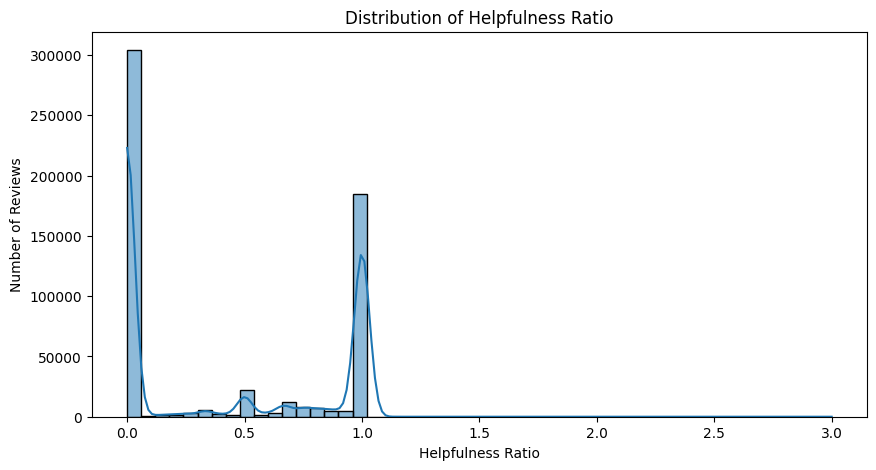

In [8]:
# Plot Helpfulness Ratio Distribution

plt.figure(figsize=(10, 5))
sns.histplot(df['helpfulness_ratio'], bins=50, kde=True)
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Number of Reviews')
plt.show()

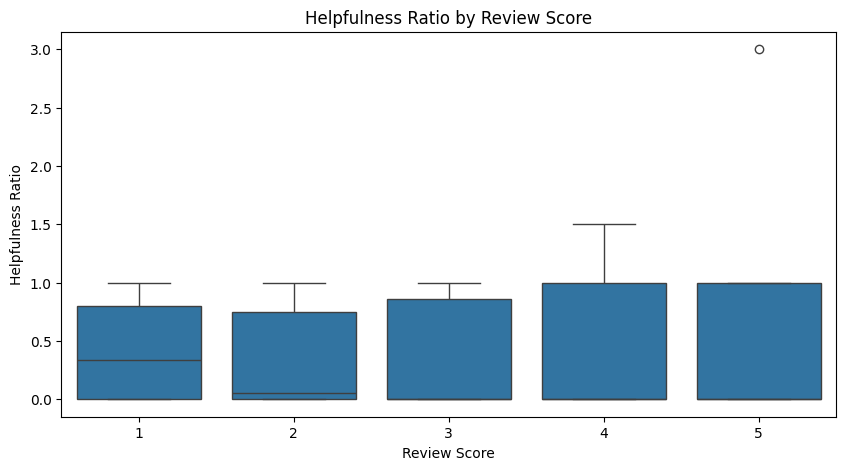

In [11]:
# Helpfulness Ration vs Score

plt.figure(figsize=(10, 5))
sns.boxplot(x='Score', y='helpfulness_ratio', data=df)
plt.title('Helpfulness Ratio by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Helpfulness Ratio')
plt.show()

####  Observation – Helpfulness Ratio

- Many reviews have a helpfulness ratio of 0 or 1, meaning users either found them not helpful at all or completely helpful.
- Reviews with higher scores (4–5) tend to be rated as slightly more helpful.
- A few outliers have ratios > 1, likely due to incorrect vote counts.

####  Action Plan (Model-Relevant)

- Consider including `helpfulness_ratio` as an **optional numeric feature** in both models (classification and regression).
- Cap extreme values (e.g., `> 1.0`) or fill missing ratios to avoid skewed inputs.
- Later, compare model performance **with and without** this feature to decide if it helps.


### 3. Review Text Analysis

This analysis helps to what words are used in different sentiments (Positive, negative and neutral) and find out whether certain pattern emerge.


In [13]:
# Word Clouds by Score

# Create sentiment groups if not already done
def map_sentiment(score):
    if score in [4, 5]:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['Score'].apply(map_sentiment)

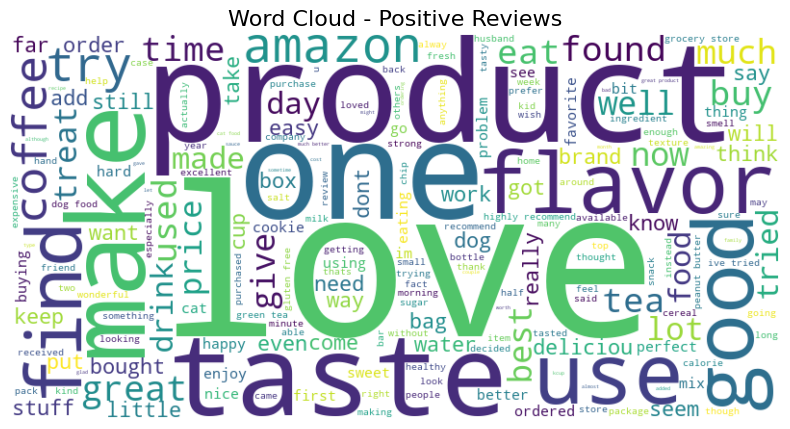

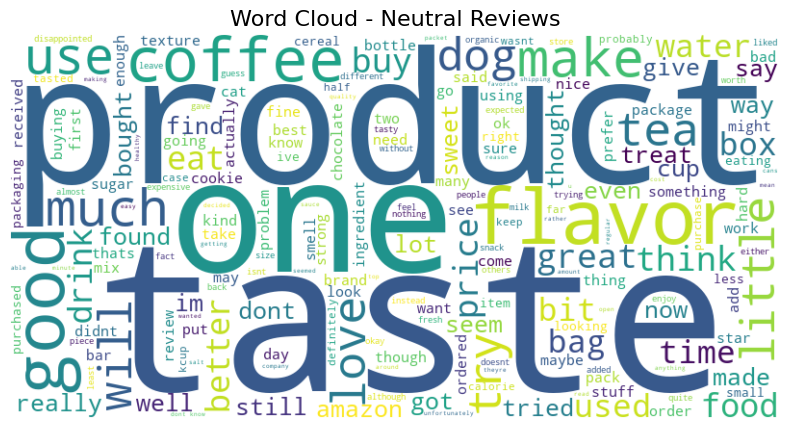

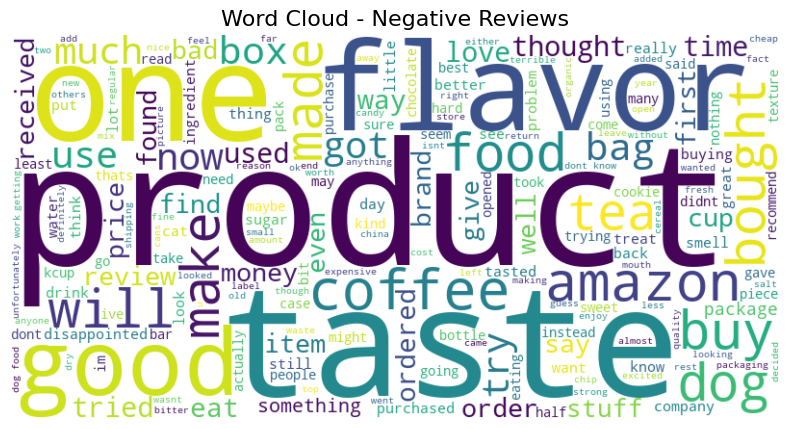

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate a word cloud
def show_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Generate text groups
positive_text = " ".join(df[df['sentiment'] == 'Positive']['cleaned_text'].dropna())
neutral_text = " ".join(df[df['sentiment'] == 'Neutral']['cleaned_text'].dropna())
negative_text = " ".join(df[df['sentiment'] == 'Negative']['cleaned_text'].dropna())

# Word clouds
show_wordcloud(positive_text, "Word Cloud - Positive Reviews")
show_wordcloud(neutral_text, "Word Cloud - Neutral Reviews")
show_wordcloud(negative_text, "Word Cloud - Negative Reviews")

####  Observation – Review Text Word Clouds

- **Positive Reviews** prominently feature words like:  
  `"love"`, `"product"`, `"taste"`, `"flavor"`, `"great"`, `"amazon"`, and `"easy"` — showing satisfaction with product quality, flavor, and convenience.

- **Neutral Reviews** still contain positive words like `"good"`, `"use"`, and `"taste"`, but with less emotional intensity. Words like `"okay"`, `"fine"`, `"expected"` or `"might"` may indicate indecision or average experience.

- **Negative Reviews** feature words such as `"taste"`, `"flavor"`, `"product"`, `"disappointed"`, `"bitter"`, and `"waste"` — indicating issues related to quality, taste, and unmet expectations.

#### Action Plan

- Use these insights to:
  - Validate the **sentiment grouping logic** used for classification.
  - Create a **custom sentiment lexicon** if needed (e.g., flagging words like “bitter” or “waste”).
  - Consider extracting **top keywords as features** using TF-IDF or CountVectorizer in modeling.


### Top 10 Most Frequent words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
# Create CountVectorizer and Fit on Cleaned Text

# Vectorizer setup: basic unigrams (individual words)
vectorizer = CountVectorizer(stop_words='english')  # removes common stopwords
X = vectorizer.fit_transform(df['cleaned_text'].dropna())

# Sum word counts
word_counts = X.sum(axis=0)
word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Convert to DataFrame
top_words_df = pd.DataFrame(word_freq[:10], columns=['Word', 'Frequency'])
top_words_df


,Word,Frequency
0,like,251389
1,good,194597
2,just,169729
3,taste,166214
4,great,162112
5,coffee,160481
6,product,146356
7,flavor,142485
8,tea,133371
9,love,126202


#### Observation – Top 10 Most Frequent Words

- The most common words in reviews are: **"like"**, **"good"**, **"just"**, **"taste"**, **"great"**, **"coffee"**, **"product"**, **"flavor"**, **"tea"**, and **"love"**.
- These terms are mostly **positive or neutral** in sentiment and reflect product experience, especially with consumables.
- Words like **"taste"**, **"flavor"**, and **"coffee/tea"** suggest the dataset may be product-focused (likely food/drink).

#### Action Plan (Applies to Both Models)

- Use top frequent terms as part of **TF-IDF vectorization** for model inputs.
- Consider filtering out **high-frequency, low-value neutral words** (e.g., “just”, “product”) to reduce noise.
- Apply TF-IDF in both the **binary classification model** and **regression model** to help extract meaningful text features.
- For classification, optionally create a **custom sentiment keyword list** (e.g., “love”, “bad”, “terrible”) to engineer sentiment-specific features.
- For regression, rely more on **overall word presence and frequency** rather than strict sentiment tags.

### 4. Correlation Analysis 

Correlation analysis helps us understand the **relationships between numerical features** in the dataset. It measures the **degree and direction** of association between variables using values between **-1 and 1**:

- **+1**: Strong positive correlation (as one increases, the other increases)
- **-1**: Strong negative correlation (as one increases, the other decreases)
- **0**: No linear correlation

In this project, correlation analysis is useful to:
- Identify which features are **predictive of the review score** (for regression)
- Understand how features relate to **positive or negative sentiment** (for classification)
- Detect **redundant or highly correlated features** that may affect model performance

We focus on features like `review_length_words`, `review_length_chars`, and `helpfulness_ratio` to assess their relationship with the target variable (`Score` or `Sentiment`).

In [18]:
# Create a numeric for the features

df['review_length_words'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
df['review_length_chars'] = df['cleaned_text'].apply(lambda x: len(str(x)))
df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, 1)


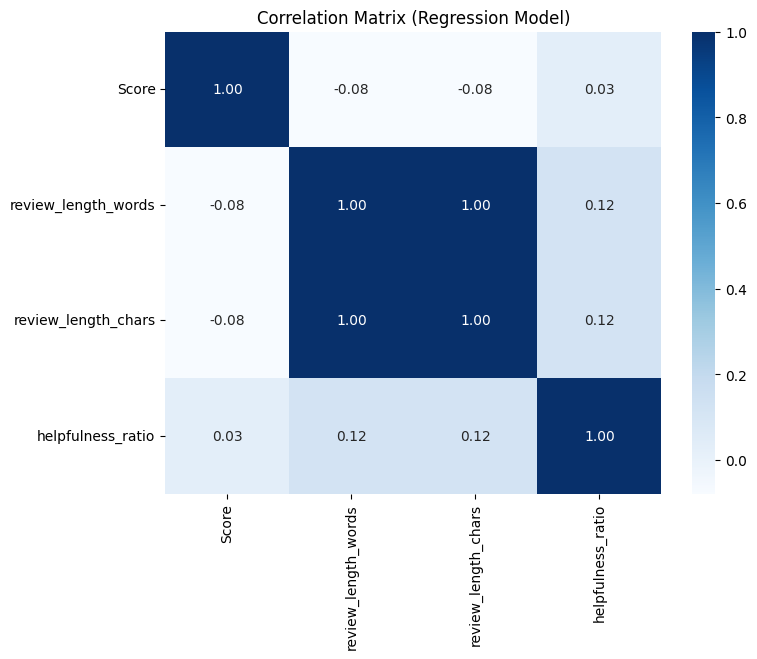

In [20]:
# Create a Correlation Matrix (For Regression)

# Select only numerical features
num_features = ['Score', 'review_length_words', 'review_length_chars', 'helpfulness_ratio']

# Compute correlation matrix
correlation_matrix = df[num_features].corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix (Regression Model)")
plt.show()

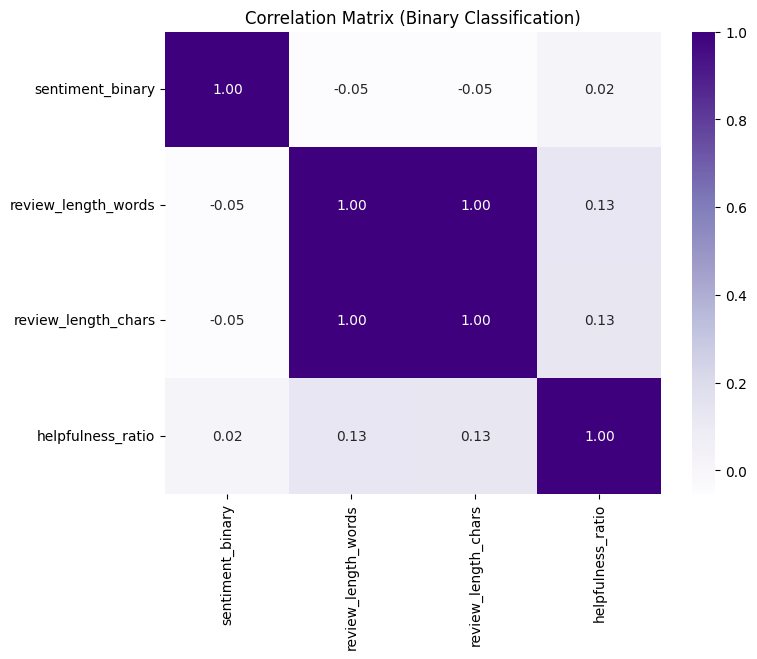

In [21]:
# For Classification
# Create binary sentiment: 1 = Positive (Score 4-5), 0 = Negative (Score 1-2)
df['sentiment_binary'] = df['Score'].apply(lambda x: 1 if x >= 4 else (0 if x <= 2 else None))

# Drop rows with None (Score=3)
df_binary = df.dropna(subset=['sentiment_binary'])

# Correlation with sentiment
corr_classification = df_binary[['sentiment_binary', 'review_length_words', 'review_length_chars', 'helpfulness_ratio']].corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_classification, annot=True, cmap='Purples', fmt=".2f")
plt.title("Correlation Matrix (Binary Classification)")
plt.show()


### Observation – Correlation Matrix

#### For Regression (`Score` as target):
- `Score` shows a **very weak negative correlation** with `review_length_words` and `review_length_chars` (-0.08).
- `helpfulness_ratio` has a **slightly positive correlation** with `Score` (0.03), but it's minimal.
- Strong correlation (1.00) exists between `review_length_words` and `review_length_chars`, which is expected.

#### For Classification (`sentiment_binary` as target):
- `sentiment_binary` has **very weak correlations** with all numeric features.
  - Slightly negative with review length (~ -0.05)
  - Almost no correlation with `helpfulness_ratio` (0.02)
- Again, strong correlation between word count and character count (1.00).

###  Action Plan

- **Include these features** (`review_length_words`, `helpfulness_ratio`) in both models, but don’t expect them to carry strong predictive power alone.
- Consider **dimensionality reduction or feature selection** later if using many text features + these.
- For modeling:
  - Keep `review_length_words` OR `review_length_chars` (not both, due to high multicollinearity).
  - Use `helpfulness_ratio` cautiously — may act as a weak signal or noise, depending on the model.



##  Final EDA Summary – Observations & Action Plans

---

###  1. Target Score Distribution

**Observation:**
- The distribution is highly imbalanced.
- ~64% of reviews have a score of 5, indicating a strong positive skew.
- Lower scores (1, 2, 3) are underrepresented.

**Action Plan:**
- For classification: drop Score = 3 and group into Positive (4–5) and Negative (1–2).
- For regression: keep all scores from 1 to 5.
- Train separate models for each approach and compare performance.

---

###  2. Helpfulness Ratio

**Observation:**
- Many reviews have a ratio of 0 or 1 — fully unhelpful or helpful.
- A few outliers exist where the ratio > 1.
- Slight positive correlation with higher review scores.

**Action Plan:**
- Cap `helpfulness_ratio` at 1.0 and handle division-by-zero cases.
- Use as an optional numeric feature in both models.
- Compare model performance with and without this feature.

---

###  3. Review Text Word Clouds

**Observation:**
- Positive reviews emphasize "love", "great", "taste", "product".
- Neutral reviews contain mild terms like "good", "okay", "use".
- Negative reviews highlight "disappointed", "bitter", "waste".

**Action Plan:**
- Use insights to support sentiment grouping (1–2 vs 4–5).
- Optionally create a custom keyword-based sentiment feature.
- Incorporate text features using TF-IDF or n-grams.

---

###  4. Top 10 Most Frequent Words

**Observation:**
- Top words include "like", "good", "taste", "coffee", "product".
- Indicates a strong food/product focus in the dataset.
- Some words like "just", "product" are high-frequency but not sentiment-relevant.

**Action Plan:**
- Use TF-IDF vectorization as input for both models.
- Optionally filter or downweight neutral high-frequency words.
- Engineer custom features using sentiment-rich words if needed.

---

###  5. Correlation Matrix

**Observation (Regression):**
- Weak correlation between `Score` and numeric features.
- Strong correlation (1.0) between `review_length_words` and `review_length_chars`.

**Observation (Classification):**
- Very weak correlation between sentiment label and features.
- Again, strong redundancy between length-based features.

**Action Plan:**
- Retain either `review_length_words` or `review_length_chars` (not both).
- Use `helpfulness_ratio` and `length` as secondary features.
- Perform feature selection if too many features are included later.

---

##  Overall Feature Engineering Plan

-  Clean + Normalize helpfulness ratio
-  Include: `review_length_words`, `helpfulness_ratio`
-  Transform text using TF-IDF vectorizer (unigrams or bigrams)
-  Drop redundant features with perfect correlation
-  Prepare:
  - `sentiment_binary` (classification)
  - `Score` (regression)
-  Handle class imbalance using `class_weight='balanced'` or `SMOTE` (for classification)

---

This structured EDA provides a solid foundation for building and evaluating both binary classification and regression models.
